# Model classificador de caràcters alfanumèrics (SVC)


Aquest arxiu conté el codi per a entrenar i avaluar un model SVC que classifica caràcters alfanumèrics utilitzant dades sintètiques. Aquestes dades no provenen de  matrícules reals, sinó que són caràcters de la mateixa font tipogràfica utilitzada en les matrícules espanyoles, on s'ha realitzat un **_data augmentation_** a partir de les lletres originals generant noves dades aplicant diferents graus de rotació. L'objectiu d'aquest entrenament és observar com es comporta el model amb dades més fàcils de predir

##### **FUNCIÓ PER CARREGAR I PREPROCESSAR LES DADES SINTÈTIQUES**

El primer pas és carregar les imatges de la carpeta "DataTrainComprimit" penjada en el repositori Github. Aquesta carpeta està formada per diferents subcarpetes on a cada una hi ha dades d'un caracter alfanumèric especific.

In [5]:
import os
import cv2
from skimage import io, color, transform


# Carreguem les imatges d'entrenament (FONT MATRÍCULA ESPANYOLA)
def load_images_from_folder(folder, label, image_size=(32, 32)):
    images = list()
    labels = list()
    # Per cada imatge de la carpeta, les processem i etiquetem
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = io.imread(img_path)
            # Transformem a l'escala HSV i ens quedem amb la capa V
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            img = img[:, :, 2] 
            # Apliquem un GaussianBlur
            cv2.GaussianBlur(img, (5, 5), 0)
            #threshold de otsu
            thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) [1]
            #Invertim la imatge, l'ajustem a una mida concreta, i l'aplanem
            negative_image = 255 - thresh
            img_resized = transform.resize(negative_image, image_size, anti_aliasing=True)
            img_flatten = img_resized.flatten()
            #Afegim la imatge i la seva etiqueta a les llistes corresponents
            images.append(img_flatten)
            labels.append(label)
            
    return images, labels

##### **FUNCIÓ PER MOSTRAR LES PREDICCIONS DEL MODEL**

Per fer un anàlisi més visual dels resultats, hem fet una funció per poder mostrar la imatge que es vol predir, la etiqueta real, i la seva predicció.

In [6]:

import matplotlib.pyplot as plt

def plot_predictions(X_test, y_test, y_pred):
    # Podem ajustar el numero de mostres, segons la llargada del dataset, com es petit hem posat que mostri totes.
    num_samples = len(y_test)
    # Número de columnes i files per visualitzar-ho millor
    cols = 10  
    rows = (num_samples + cols - 1) // cols  

    plt.figure(figsize=(15, rows * 1.5))
    
    # Per cada mostra mostrem la imatge, la etiqueta real i la seva predicció
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        img = X_test[i].reshape(32, 32)  # 
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Real: {y_test[i]}\nPred: {y_pred[i]}")
    
    plt.tight_layout()
    plt.show()


##### **FUNCIÓ PER ENTRENAR I AVALUAR LES DADES EN K-FOLDS**

Una bona manera per entrenar i avaluar dades és utilitzant K-Folds cross validation, en comptes a fer un simple split de train i test. Fa una millor estimació del rendiment, ja que, la evaluació del model no depen completament de com s'ha realitzat la divisió. Podem obtenir conjunts molt dificils de predir o molt predictius. K-Folds divideix les dades en K subcoinjunts i realitza l'entrenament i l'avaluació K vegades.

In [7]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 


def Train_KFolds(X,Y):
    
    # Inicialitzem el model SVC
    clf = svm.SVC(kernel='linear', probability=True)

    # Inicialitzem llistes per guardar les etiquetes predites i reals del dataset i les accuracies dels Kfolds
    accuracies = [] 
    all_y_true = []
    all_y_pred = []
    
    
    # Cridem la funció KFold per generar 5 subconjunts
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  
    
    # Ejecutar el bucle de K-Folds
    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Entrenem el model
        clf.fit(X_train, y_train)
        
        # Realitzem les prediccions amb el conjunt de prova
        y_pred = clf.predict(X_test)
        
        # Calculem y emmagatzem la accuracy del fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        # Mostrem els resultats del fold actual
        print(f'Fold {fold} - Precisión: {accuracy:.2f}')
        
        # Acumulem les etiquetes reals i predites a les llistes corresponents
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        
        # Visualitzem les prediccions
        plot_predictions(X_test, y_test, y_pred) 
        
    return kf, all_y_true, all_y_pred, accuracies

##### **CODI PRINCIPAL I AVALUACIONS GENERALS DEL MODEL**

Un cop fetes les funcions auxiliars, hem creat un codi principal on es criden aquestes funcions i es realitza una matriu de confusió global amb els resultats dels diferents Folds.

Fold 1 - Precisión: 0.97


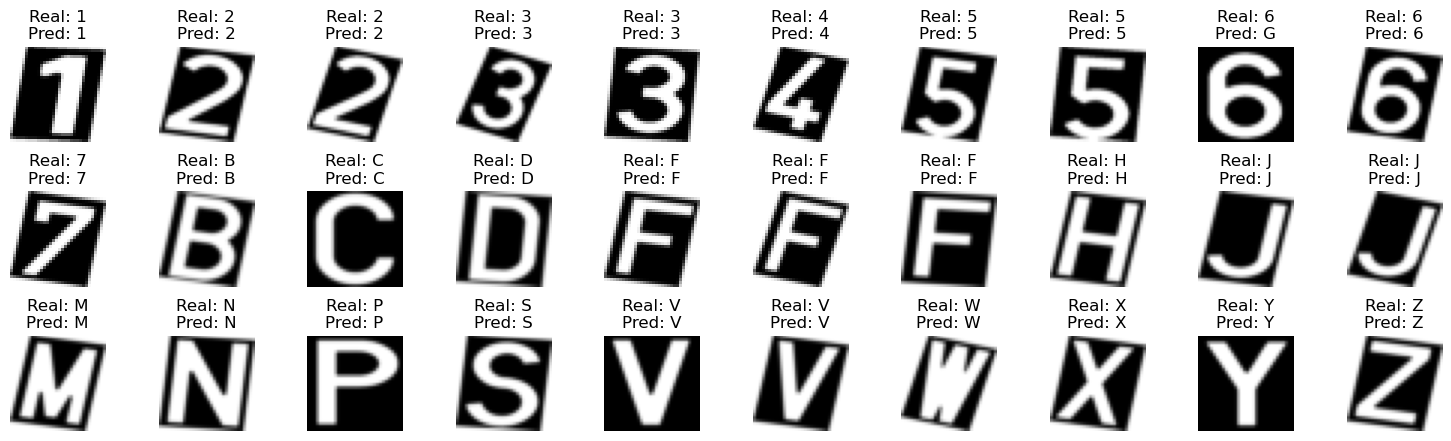

Fold 2 - Precisión: 0.90


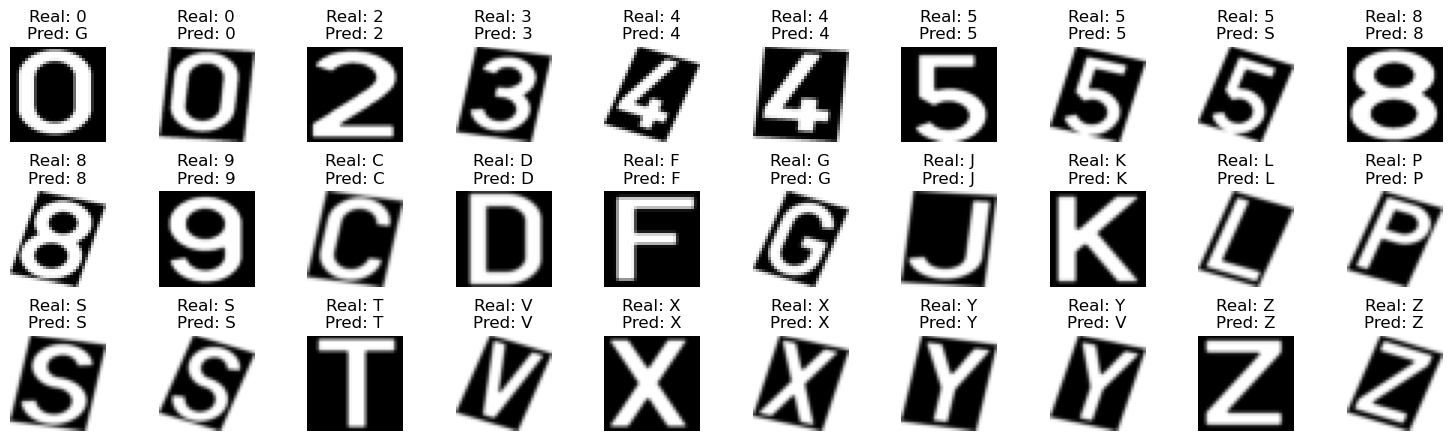

Fold 3 - Precisión: 0.90


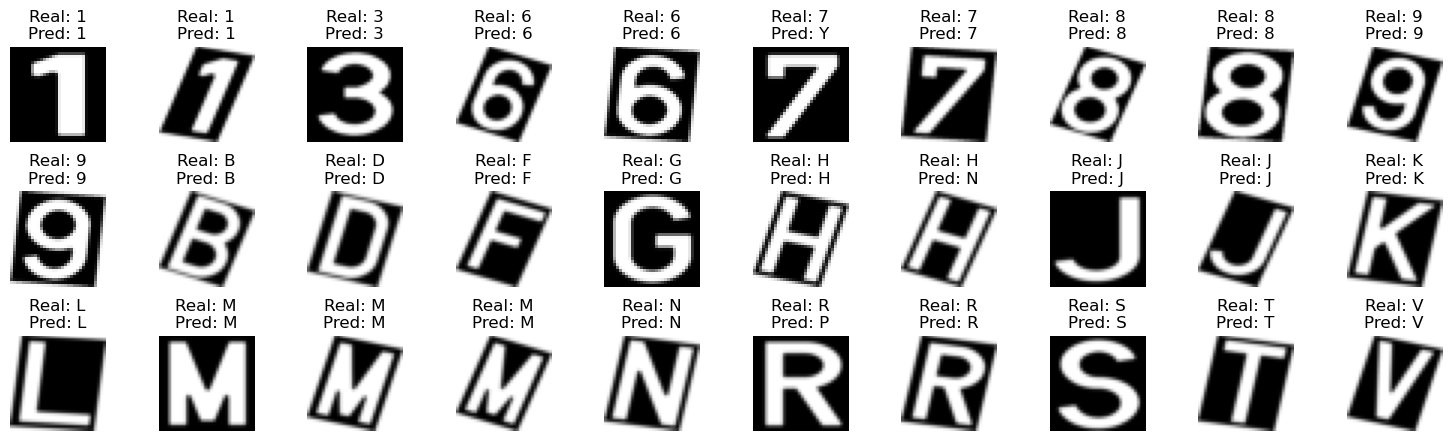

Fold 4 - Precisión: 0.90


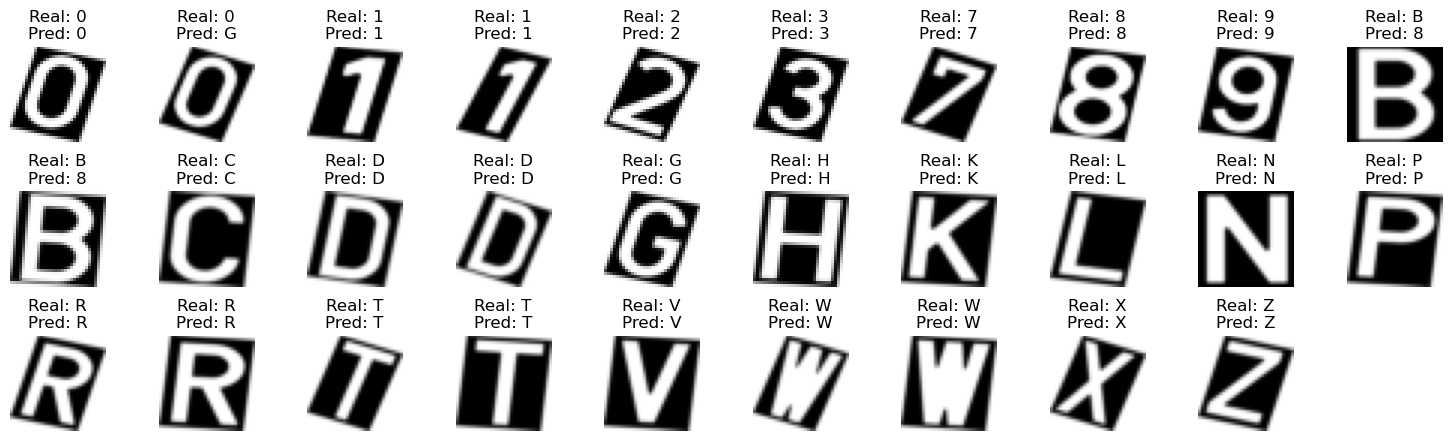

Fold 5 - Precisión: 0.97


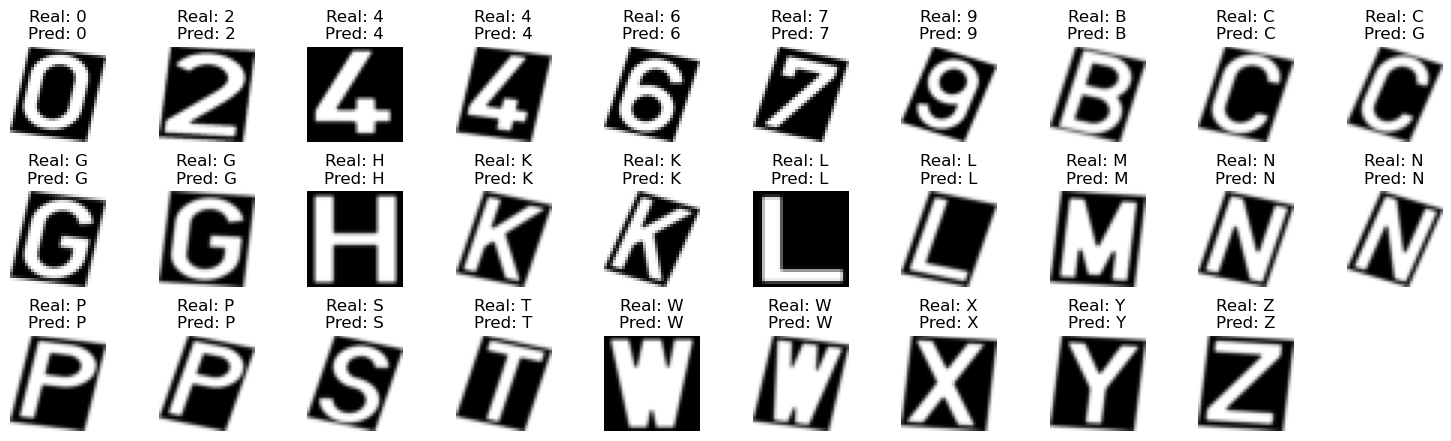

Precisión promedio en los 5 folds: 0.93


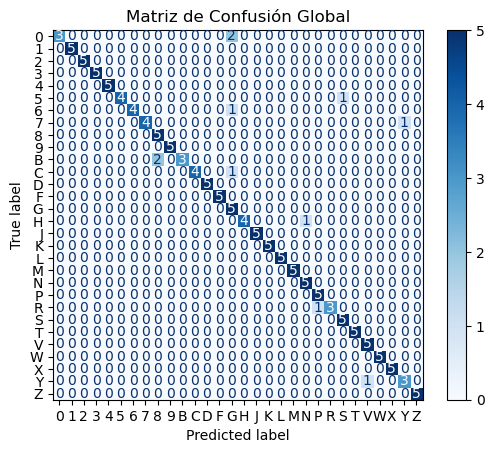

In [8]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt


# PAS 1: Llegim les dades i les guardem en els arrays corresponents

# Llista de caracters alfanumèrics 
caracteres = '0123456789BCDFGHJKLMNPRSTVWXYZ'

data = []
target = []

# Trobem el directori actual
base_path =  os.getcwd()

# Per cada caracter busquem la seva carpeta corresponent on hi ha les imatges que s'han d'etiquetar amb el caracter.
for char in caracteres:
    folder_path = os.path.join(base_path, char)
    images, labels = load_images_from_folder(folder_path, char)
    data.extend(images)
    target.extend(labels)
    
# Convertim les dades en a arrays numpy
X = np.array(data)
Y = np.array(target)
    
# Cridem la funció per entrenar i avaluar el model amb KFolds
kf, all_y_true, all_y_pred, accuracies = Train_KFolds(X,Y)
    
    
# Calculem la mitjana dels accuracies dels diferents Folds
mean_accuracy = np.mean(accuracies)
print(f'Precisión promedio en los {kf.n_splits} folds: {mean_accuracy:.2f}')

# Fem una matriu de confussió general per observar els resultats d'una manera més visual.
cm_global = confusion_matrix(all_y_true, all_y_pred)
disp_global = ConfusionMatrixDisplay(confusion_matrix=cm_global, display_labels=np.unique(Y))
disp_global.plot(cmap='Blues')
plt.title("Matriz de Confusión Global")
plt.show()



